# Part 1: Initial Planning

## Robert, Dave and Stan
--------------------------------------------------------------------------------------------------------------------------------


### We hope to predict the winner of the 2018 NBA Playoffs 
### Collected data from 
  1. https://www.cbssports.com/nba/standings 
  2. https://www.kaggle.com/pablote/nba-enhanced-stats 
  3. https://stats.nba.com/teams/traditional/?sort=W_PCT&dir=-1&Season=2017-18&SeasonType=Regular%20Season 
                       

Question: Can we predict, using statistics from the regular season, the outcome of the playoffs. We want to investigate if we can successfully have a model that identifies key features in a winning team and then can predict future winners. The plan is to have the model train on statistics from previous seasons and associate those with the teams that won, and then run the statistics from this past current season to see who will win the playoffs. 

Import necessary libraries 

In [6]:
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import ttest_ind
import math

Read box statistics from 2016/2017 season and 2017/2018
  * Note that these are not yet used

In [27]:
team_box1617 = pd.read_csv("./2016-17_teamBoxScore.csv", sep=',', dtype = str)
player_box1617 = pd.read_csv("./2016-17_playerBoxScore.csv", sep=',', dtype = str)
official_box1617 = pd.read_csv("./2016-17_officialBoxScore.csv", sep=',', dtype = str)
standings1617 = pd.read_csv("./2016-17_standings.csv", sep=',', dtype = str)
team_box1718 = pd.read_csv("./2017-18_teamBoxScore.csv", sep=',', dtype = str)
player_box1718 = pd.read_csv("./2017-18_playerBoxScore.csv", sep=',', dtype = str)
official_box1718 = pd.read_csv("./2017-18_officialBoxScore.csv", sep=',', dtype = str)
standings1718 = pd.read_csv("./2017-18_standings.csv", sep=',', dtype = str)

Below we are attempting to understand the box player statistics, it is difficult to understand exactly what these are because 
we cannot divide it into teams, we will continue to investigate this more for the next deliverable.

In [26]:
player_box1617 = player_box1617[player_box1617["teamAbbr"] == 'GS']
player_box1617.head()

,gmDate,gmTime,seasTyp,playLNm,playFNm,teamAbbr,teamConf,teamDiv,teamLoc,teamRslt,...,playFT%,playORB,playDRB,playTRB,opptAbbr,opptConf,opptDiv,opptLoc,opptRslt,opptDayOff
59,2016-10-25,10:30,Regular,Durant,Kevin,GS,West,Pacific,Home,Loss,...,0.8,0,10,10,SA,West,Southwest,Away,Win,0
60,2016-10-25,10:30,Regular,Curry,Wardell,GS,West,Pacific,Home,Loss,...,0.8333,0,3,3,SA,West,Southwest,Away,Win,0
61,2016-10-25,10:30,Regular,Thompson,Klay,GS,West,Pacific,Home,Loss,...,0.0,0,1,1,SA,West,Southwest,Away,Win,0
62,2016-10-25,10:30,Regular,Green,Draymond,GS,West,Pacific,Home,Loss,...,1.0,5,7,12,SA,West,Southwest,Away,Win,0
63,2016-10-25,10:30,Regular,Pachulia,Zaza,GS,West,Pacific,Home,Loss,...,0.0,1,2,3,SA,West,Southwest,Away,Win,0


Read csv file that has been scraped from cite 1.
  * The data that we scraped came with some issues. First of all there was a column with no information that needed to be deleted. As well as two columns representing the conference names. This cleaning occurs in the code below.

In [8]:
'''This code readings the recent years team statistics from the scraped web csv. Oddly, the data downloaded with an 
extra column that had no data that we wanted to collect. In orfer to remove this column, its deleted. It was also necessary
to remove the two columns with extra titles and conferences for the following teams. Thus, they are dropped.'''

names = ["Team", "W", "L", 'Pct', 'GB', 'Home', 'Road', "Conf", "Div", "Streak", "L10", "?"]
team_statistics = pd.read_csv("./scraping_attempt2.csv", sep = ',', dtype = str, names = names)
del team_statistics['?']
team_statistics.drop(0, inplace=True)
team_statistics.drop(16, inplace=True)
#team_statistics

Read csv files from end of year statistsics from the past 4 years

In [9]:
team_stats1415 = pd.read_csv("./Stats_14-15.csv", sep = ",")
team_stats1516 = pd.read_csv("./Stats_15-16.csv", sep = ",")
team_stats1617 = pd.read_csv("./Stats_16-17.csv", sep = ",")
team_stats1718 = pd.read_csv("./Stats_17-18.csv", sep = ",")

Data Munging: Here we needed to do an addition so that we can have to total number of games played within the dataframe. 
    Hence we add the number of wins and the number of losses. Further below we delete a column that is useless in the table. It is full of NaN. Finally, we want to get the top teams from each year. We decide that the top teams will be identified with a winning percent above 60%.

In [10]:
'''GENERATES MISSING GAMES PLAYED COLUMN'''
team_stats1415['GP'] = team_stats1415['W'] + team_stats1415['L']
team_stats1516['GP'] = team_stats1516['W'] + team_stats1516['L']
team_stats1617['GP'] = team_stats1617['W'] + team_stats1617['L']
team_stats1718['GP'] = team_stats1718['W'] + team_stats1718['L']

In [11]:
'''DELETES USELESS "MIN" COLUMN... JUST NaN FOR ALL'''
del team_stats1415["MIN"]
del team_stats1516["MIN"]
del team_stats1617["MIN"]
del team_stats1718["MIN"]

In [12]:
'''GENERATES DATAFRAMES OF TEAMS WITH WIN% OVER 60%'''
top_teams1415 = team_stats1415[team_stats1415["WIN%"] > .6]
top_teams1516 = team_stats1516[team_stats1516["WIN%"] > .6]
top_teams1617 = team_stats1516[team_stats1617["WIN%"] > .6]
top_teams1718 = team_stats1516[team_stats1718["WIN%"] > .6]

C:\Users\Robert\Anaconda\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


In [13]:
'''TRIMS COLUMNS OF TOP TEAMS TO FOCUS ON "TEAM", "W", "L", "WIN%", "PTS"'''
top_team_stats_1415 = top_teams1415[["TEAM", "W", "L", "WIN%", "PTS"]]
top_team_stats_1516 = top_teams1516[["TEAM", "W", "L", "WIN%", "PTS"]]
top_team_stats_1617 = top_teams1617[["TEAM", "W", "L", "WIN%", "PTS"]]
top_team_stats_1718 = top_teams1718[["TEAM", "W", "L", "WIN%", "PTS"]]

Scatter plot for WIN% VS 3PM in regular season
Clearly the teams made really low 3-pointers having low win%
However, above the certain line, 3-pointers obviously was not the only critical factor affecting win%.

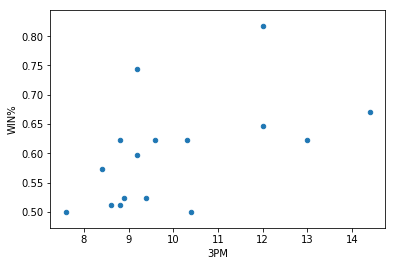

In [14]:
'''THIS BUILDS THE SCATTER PLOT SHOWING 3-POINTERS MADE AND WIN %'''
scat_1617 = team_stats1617[["TEAM", "WIN%", "3PM"]]
scat_1617.plot(x='3PM', y='WIN%', kind='scatter')

The bar chart below is representing all teams with a win percentage above 60%. The teams are in decreasing over starting from the left and going to the right. The goal is to visualize if average points scored in a game is correlated with the number of wins. 

In [ ]:
'''THIS PLOTS TEAMS WITH WIN% > 60%'''
top_team_stats_1415.plot(figsize = (15, 5), kind="bar", grid = True)

Below we are investigating again the statistics from the two teams who played in the final. It is evident that the Golden State Warriors were better in a number of statistics including win percentage, field goals made, and 3 point attempts. This is 
significant because there is a possibility that those statistics can be associated with a winning team. We will want to investigate this more and in more of the past years to establish stronger reliability. 

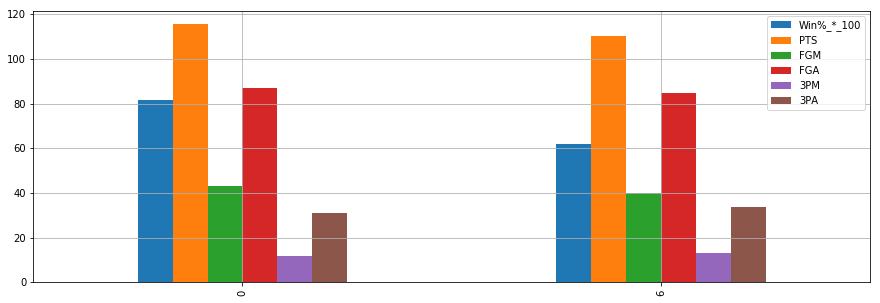

In [18]:
'''THIS IS TO PLOT THE 2017 FINALS STATS'''
gs_1617 = team_stats1617[team_stats1617['TEAM'] == 'Golden_State_Warriors']
cc_1617 = team_stats1617[team_stats1617['TEAM'] == 'Cleveland_Cavaliers']
frames = [gs_1617, cc_1617]
#finals_1617 = pd.concat(frames)
#finals_1617
finals_1617["Win%_*_100"] = finals_1617["WIN%"] * 100
finals_stats_1617 = finals_1617[["TEAM","Win%_*_100", "PTS", "FGM", "FGA", "3PM", "3PA"]]
finals_stats_1617.plot(figsize = (15, 5), kind="bar", grid = True)

The stats below are for both teams from regular season.
Clearly Cleveland Cavaliers are losing in each stat, however, they won the match up.
We would like to consider the match up as an outliar. And the possible cause would be the explosion of certain players. In this case, they are Lebron James and Kyrie Irving.
We would not take certain players into consideration since it would be much more complicated , also the players' stats are not easily accesible, and players change teams every year.

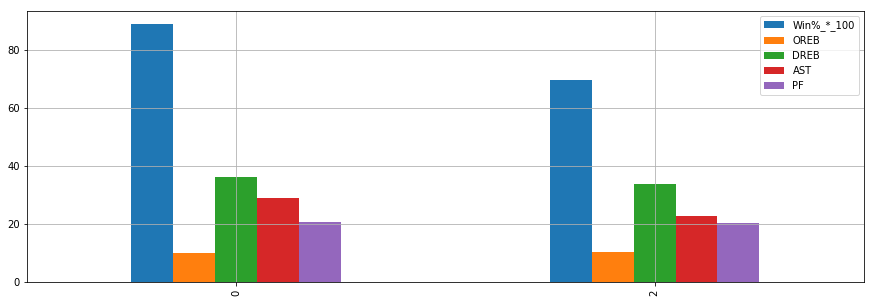

In [17]:
'''THIS IS TO PLOT THE 2016 FINALS STATS'''
gs_1516 = team_stats1516[team_stats1516['TEAM'] == 'Golden_State_Warriors']
cc_1516 = team_stats1516[team_stats1516['TEAM'] == 'Cleveland_Cavaliers']
frames = [gs_1516, cc_1516]
finals_1516 = pd.concat(frames)
# finals_1516
finals_1516["Win%_*_100"] = finals_1516["WIN%"] * 100
finals_stats_1516 = finals_1516[["TEAM","Win%_*_100", "OREB", "DREB", "AST", "PF"]]
finals_stats_1516.plot(figsize = (15, 5), kind="bar", grid = True)